<a href="https://colab.research.google.com/github/afifaniks/tiny_brains/blob/rnd-notebooks/contrast_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import monai


In [ ]:
from monai.transforms import (LoadImaged, EnsureChannelFirstd, ScaleIntensityd, RandCropByPosNegLabeld,\
                             RandAxisFlipd, RandGaussianNoised, RandGibbsNoised, RandSpatialCropd, Compose, \
                             CropForegroundd,AdjustContrastd, LoadImage)

In [ ]:
import numpy as np

def contrast_inversion(image, mask):
    max_intensity = np.max(image[mask.astype(int)])
    inverted_image = np.where(mask, max_intensity - image, image)
    return inverted_image

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
source_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        EnsureChannelFirstd(keys=["img"]),
        ScaleIntensityd(
            keys=["img"],
            minv=0.0,
            maxv=1.0
        ),
        # RandSpatialCropd(keys=["img"], roi_size=(112, 112, 112), random_size=False),
        #RandCropByPosNegLabeld(
        #    keys=["img", "brain_mask"],
        #    spatial_size=(64, 64, 64),
        #    label_key="brain_mask",
        #    pos = 0.9,
        #    neg=0.1,
        #    num_samples=1,
        #    image_key="img",
        #    image_threshold=-0.1
        #),
        AdjustContrastd(keys=["img"], gamma=2.0),
        # RandAxisFlipd(keys=["img"], prob = 0.2),
        RandGaussianNoised(keys = ["img"], prob=0.2, mean=0.0, std=0.05),
        RandGibbsNoised(keys=["img"], prob = 0.2, alpha = (0.1,0.6))
    ]
)

In [ ]:
image_path = "CC0001_philips_15_55_M.nii"
image = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(image_path)

In [ ]:
image_mask_path = "CC0001_philips_15_55_M_staple.nii"
image_mask = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(image_mask_path)

In [ ]:
def min_max_normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

In [ ]:
im_c = image.squeeze().numpy()
im_mask_c = image_mask.squeeze().numpy()

In [ ]:
source = im_c #[:, :, 160]
mask = im_mask_c #[:, :,160]

In [ ]:
source = min_max_normalize(source)

In [ ]:
def reversed_contrast(image, mask):
  mask = mask.astype(bool)

  max_intensity = np.max(image[mask])

  print(max_intensity)

  reversed_image = image.copy()
  reversed_image[mask] = max_intensity - image[mask]

  return reversed_image

In [ ]:
inverted_mri_image = reversed_contrast(source, mask)
# max_value = np.max(inverted_mri_image)
# inverted_mri_image[mask != 0] = mask[mask != 0] - inverted_mri_image[mask != 0]

0.5372051


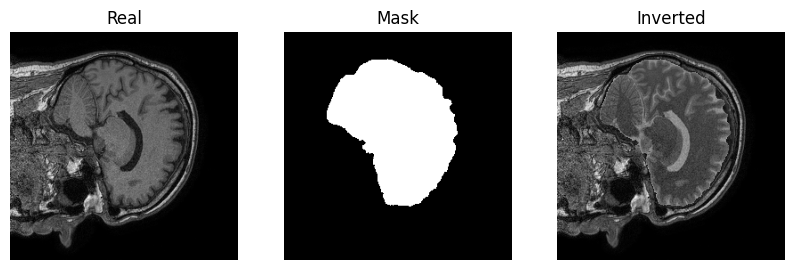

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axs[0].imshow(source[70, :, :], cmap="gray")
axs[0].set_title('Real')

axs[1].imshow(mask[70, :, :], cmap="gray")
axs[1].set_title('Mask')

axs[2].imshow(inverted_mri_image[70, :, :], cmap="gray")
axs[2].set_title('Inverted')

for ax in axs:
    ax.axis('off')

plt.show()

In [ ]:
contrast_inversion(im_c, im_mask_c)

In [ ]:
max_value = np.max(inverted_mri_image)

1067.071

test


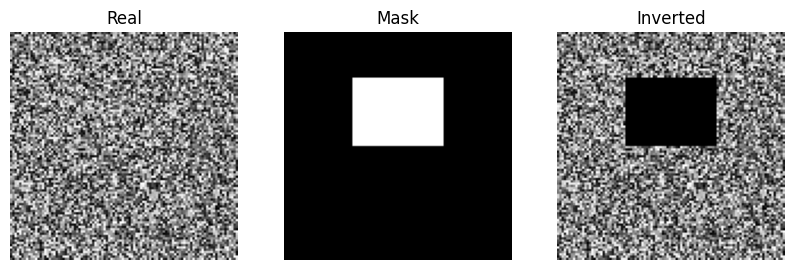

In [ ]:
import numpy as np

def subtract_inside_mask(original_image, mask):
    # Ensure the mask is binary (0 or 1)
    mask = mask.astype(bool)
    print("test")

    # Create a copy of the original image
    result_image = np.copy(original_image)

    # Subtract the original pixel value from the mask where the mask is 1
    result_image[mask] -= original_image[mask]

    return result_image

# Example usage:
# Assume 'brain_image' is your original brain image and 'brain_mask' is your brain mask image
# Make sure 'brain_image' and 'brain_mask' have the same dimensions

# Example brain image and mask (random numbers for demonstration)
brain_image = np.random.randint(0, 256, size=(100, 100))
brain_mask = np.zeros_like(brain_image)
brain_mask[20:50, 30:70] = 1  # Example brain mask region

result_image = subtract_inside_mask(brain_image, brain_mask)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

axs[0].imshow(brain_image, cmap="gray")
axs[0].set_title('Real')

axs[1].imshow(brain_mask, cmap="gray")
axs[1].set_title('Mask')

axs[2].imshow(result_image, cmap="gray")
axs[2].set_title('Inverted')

for ax in axs:
    ax.axis('off')

plt.show()


In [ ]:
image_mask.shape

torch.Size([1, 171, 256, 256])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def threshold(x):
    # threshold at 1
    return x > 0.015

In [ ]:
target_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        EnsureChannelFirstd(keys=["img"]),
        ScaleIntensityd(keys=["img"], minv=0.0, maxv=1.0),
        # CropForegroundd(keys=["img"], source_key = "img", select_fn=threshold, margin=3),
        # RandSpatialCropd(keys=["img"], roi_size=(112, 112, 112), random_size=False),
        RandGaussianNoised(keys = ["img"], prob=0.2, mean=0.0, std=0.05),
        RandGibbsNoised(keys=["img"], prob = 0.2, alpha = (0.1,0.6)),
        # RandAxisFlipd(keys=["img"], prob = 0.2)
    ]
)

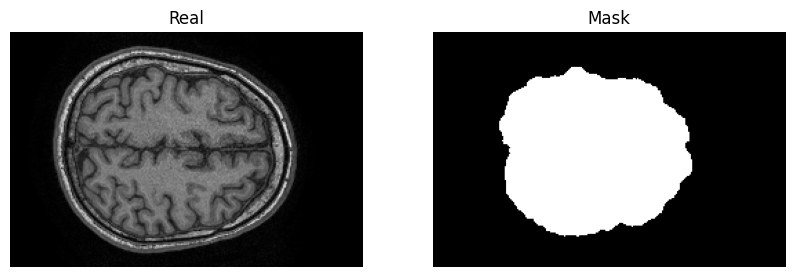

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# source = image[0, image.shape[1]//2, :, :]
# src_aug = src_transform["img"][0,image.shape[1]//2,:,:]
# aug = transforms["img"][0,image.shape[1]//2,:,:]

# source = image[0, :, :, 160]
# src_aug = src_transform["img"][0,:,:,160]
# aug = transforms["img"][0,:,:,160]

# source = im_c[:, 160, :]
# mask = im_mask_c[:,160,:]

source = im_c[:, :, 160]
mask = im_mask_c[:, :,160]

axs[0].imshow(source, cmap="gray")
axs[0].set_title('Real')

axs[1].imshow(mask, cmap="gray")
axs[1].set_title('Mask')

for ax in axs:
    ax.axis('off')

plt.show()

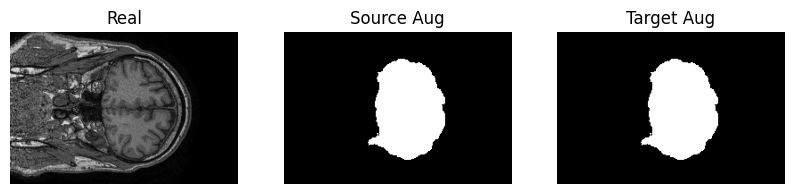

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns

# source = image[0, image.shape[1]//2, :, :]
# src_aug = src_transform["img"][0,image.shape[1]//2,:,:]
# aug = transforms["img"][0,image.shape[1]//2,:,:]

# source = image[0, :, :, 160]
# src_aug = src_transform["img"][0,:,:,160]
# aug = transforms["img"][0,:,:,160]

source = image[0, :, 160, :]
src_aug = src_transform["img"][0,:,160,:]
aug = transforms["img"][0,:,160,:]

axs[0].imshow(source, cmap="gray")
axs[0].set_title('Real')

axs[1].imshow(src_aug, cmap="gray")
axs[1].set_title('Source Aug')

axs[2].imshow(aug, cmap="gray")
axs[2].set_title('Target Aug')


for ax in axs:
    ax.axis('off')

plt.show()